# Projet P12 - Détectez des faux billets avec R ou Python

## <font>Sommaire</font>

**[Contexte du projet et missions](#Presentation_projet)**

**[Partie 1 - Analyse exploratoire](#partie1)**
* [1. Importation des librairies](#1_1)
* [2. Les Outliers](#1_2)
* [3. Analyse Univariée](#1_3)
* [4. Analyse Bivariée](#1_4)
* [5. ACP](#1_5)
* [6. Regression lineaire multiple](#1_6)

**[Partie 2 - les Algorithmes utilisés pour detecter les vrais/faux billets](#partie_2)**
* [1. K Means](#2_1)
* [2. Regression Logistique](#2_2)
* [3. KNN](#2_3)
* [4. Random Forest](#2_4)
* [5. Gradient Boosting](#2_5)
* [6. Comparaison des performances](#2_6)

# <font>Contexte du projet et missions<a class="anchor" id="Presentation_projet"></a></font>

L'Organisation nationale pour la lutte contre la contrefaçon des billets (ONCFM) est une entité publique dont la mission est de développer des techniques permettant d'identifier les billets contrefaits en euros. Dans cette démarche, ils souhaitent mettre en œuvre un algorithme capable de distinguer automatiquement les vrais billets des faux.

Lorsque qu’un billet est analysé, une machine enregistre toutes ses caractéristiques géométriques. Au fil des années, l'ONCFM a constaté des différences dimensionnelles subtiles entre les billets authentiques et les faux. Ces variations sont difficilement détectables à l'œil nu, mais une machine peut aisément les repérer. Ainsi, l'objectif de ce projet est de créer un algorithme qui, à partir des dimensions d'un billet, sera en mesure de déterminer automatiquement s'il s'agit d'un original ou d'une contrefaçon.

## <font>Partie 1 - Analyse exploratoire<a class="anchor" id="#partie1"></a></font>

## <font>1. Importation des librairies et de la data<a class="anchor" id="#1_1"></a></font>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, r2_score, roc_curve, roc_auc_score, auc, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans

In [2]:
# Importation et aperçu du data frame
billets = pd.read_csv('billets.csv', sep=";")
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
billets.shape

(1500, 7)

In [4]:
billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


'is_genuine' : variable qualitative binaire

valeurs manquantes pour 'margin_low'

plus grands écart-types pour 'margin_low' et 'lenght'

In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [7]:
billets.loc[billets['margin_low'].isna()].groupby('is_genuine')['diagonal'].count()

is_genuine
False     8
True     29
Name: diagonal, dtype: int64

In [8]:
billets.duplicated().sum()

0

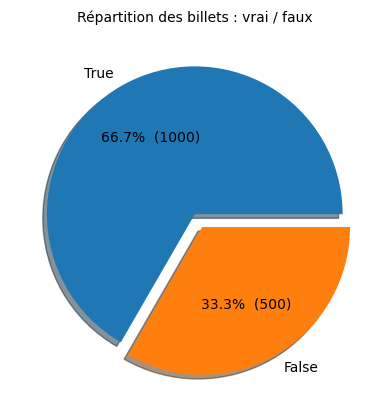

In [9]:
# Proportion de faux billets
data = billets['is_genuine'].value_counts()

# Fonction pour afficher les pourcentages sur le pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct, v=val)
    return my_autopct

# Création du pie chart
plt.pie(data, 
        labels=['True', 'False'],
        autopct=make_autopct(data),
        textprops={'fontsize': 10},
        explode=(0, 0.1), 
        shadow=True)

plt.title("Répartition des billets : vrai / faux", fontsize=10)

# Affichage du graphique
plt.show()

## <font>2. Les Outliers<a class="anchor" id="1_2"></a></font>

In [10]:
column = billets.columns[1:].to_list()

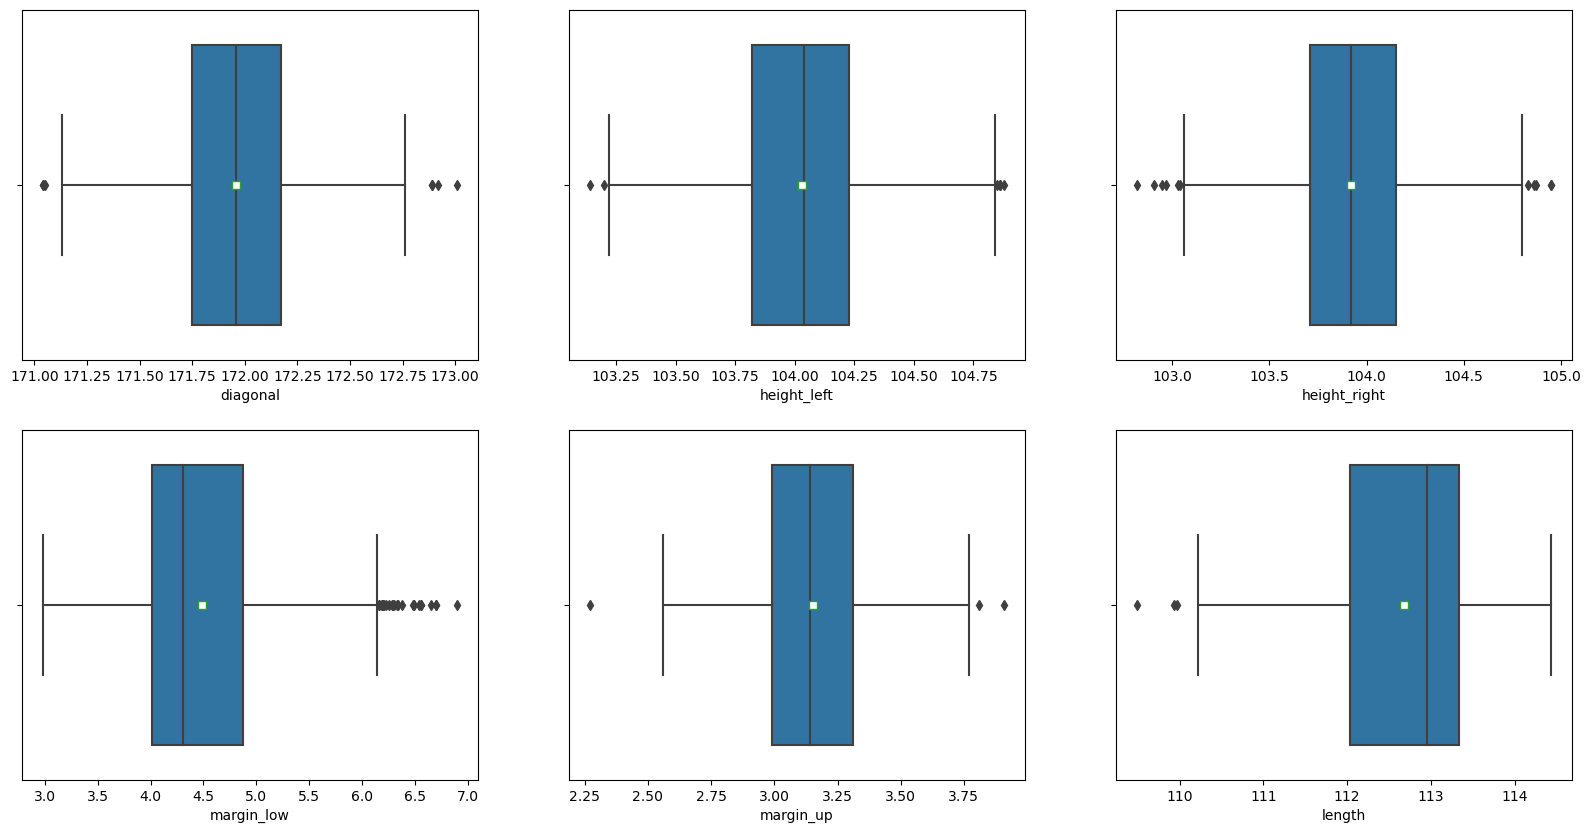

In [11]:
# Boxplots et outliers pour les différentes colonnes du df 
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.boxplot(data=billets, x=col, 
                showmeans=True, 
                meanprops={"marker":"s","markerfacecolor":"white"},
                ax=ax[q, mod])
plt.show()
 

In [12]:
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64']):  # Sélection des colonnes numériques
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        
    return outliers

# Exemple d'utilisation avec votre DataFrame 'billets'
outliers = detect_outliers(billets)
for col, values in outliers.items():
    print(f"Outliers pour la colonne {col}:")
    print(values)

Outliers pour la colonne diagonal:
729     171.04
828     172.92
842     172.89
1022    172.89
1142    171.04
1277    173.01
1388    171.05
Name: diagonal, dtype: float64
Outliers pour la colonne height_left:
0       104.86
224     103.20
292     103.14
1090    104.88
1150    104.86
1382    104.85
Name: height_left, dtype: float64
Outliers pour la colonne height_right:
0       104.95
77      103.03
176     102.97
193     102.95
251     102.82
522     102.91
761     103.04
1199    104.87
1321    104.86
1331    104.83
1484    104.95
Name: height_right, dtype: float64
Outliers pour la colonne margin_low:
1023    6.20
1027    6.70
1031    6.33
1041    6.65
1053    6.21
1075    6.23
1092    6.30
1110    6.56
1124    6.70
1133    6.16
1134    6.34
1169    6.48
1254    6.49
1290    6.90
1322    6.19
1345    6.16
1348    6.28
1353    6.19
1420    6.38
1426    6.25
1441    6.56
1459    6.19
1464    6.54
1473    6.29
Name: margin_low, dtype: float64
Outliers pour la colonne margin_up:
664     2.

In [13]:
# Le dictionnaire des outliers
outliers = {
    'diagonal': [729, 828, 842, 1022, 1142, 1277, 1388],
    'height_left': [0, 224, 292, 1090, 1150, 1382],
    'height_right': [0, 77, 176, 193, 251, 522, 761, 1199, 1321, 1331, 1484],
    'margin_low': [1023, 1027, 1031, 1041, 1053, 1075, 1092, 1110, 1124, 1133, 1134, 1169, 1254, 1290, 1322, 1345, 1348, 1353, 1420, 1426, 1441, 1459, 1464, 1473],
    'margin_up': [664, 1029, 1270],
    'length': [1082, 1355, 1453]
}

# Pour chaque variable d'outliers, afficher si ces billets sont authentiques ou non
for variable, indices in outliers.items():
    print(f"Outliers pour la colonne '{variable}':")
    outliers_genuine_status = billets.loc[indices, ['is_genuine', variable]]
    print(outliers_genuine_status, '\n')

Outliers pour la colonne 'diagonal':
      is_genuine  diagonal
729         True    171.04
828         True    172.92
842         True    172.89
1022       False    172.89
1142       False    171.04
1277       False    173.01
1388       False    171.05 

Outliers pour la colonne 'height_left':
      is_genuine  height_left
0           True       104.86
224         True       103.20
292         True       103.14
1090       False       104.88
1150       False       104.86
1382       False       104.85 

Outliers pour la colonne 'height_right':
      is_genuine  height_right
0           True        104.95
77          True        103.03
176         True        102.97
193         True        102.95
251         True        102.82
522         True        102.91
761         True        103.04
1199       False        104.87
1321       False        104.86
1331       False        104.83
1484       False        104.95 

Outliers pour la colonne 'margin_low':
      is_genuine  margin_low
1023      

## <font>3. Analyse Univariée<a class="anchor" id="1_3"></a></font>

In [14]:
billets[billets.is_genuine==True].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [15]:
billets[billets.is_genuine==False].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


La description des vrais et faux billets nous montre que :
* les vrais billets sont plus longs que les faux
* les faux billets ont une marge inférieure, 'margin_low', plus grande que les vrais.
* la diagonale est très proche entre les vrais et faux billets
* les hauteurs droites et gauches sont légèrement supérieures pour les faux billets.

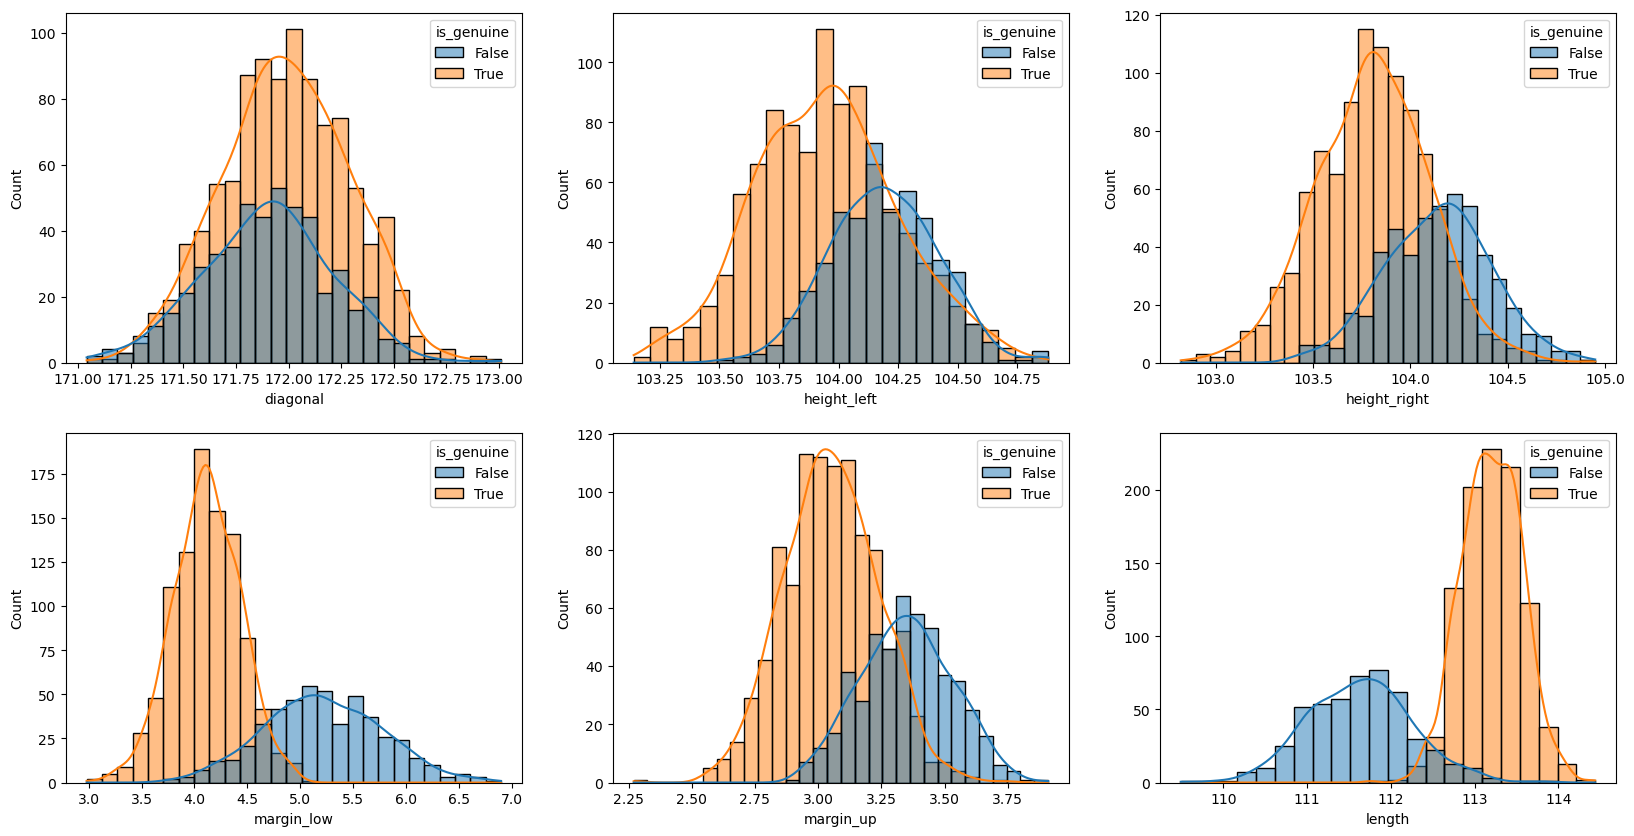

In [16]:
# Distribution des dimensions
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.histplot(data=billets, x=col, hue='is_genuine', kde=True, ax=ax[q, mod])
plt.show()

diagonal -> non significative

length -> variable bien plus différenciée entre les vrais/faux

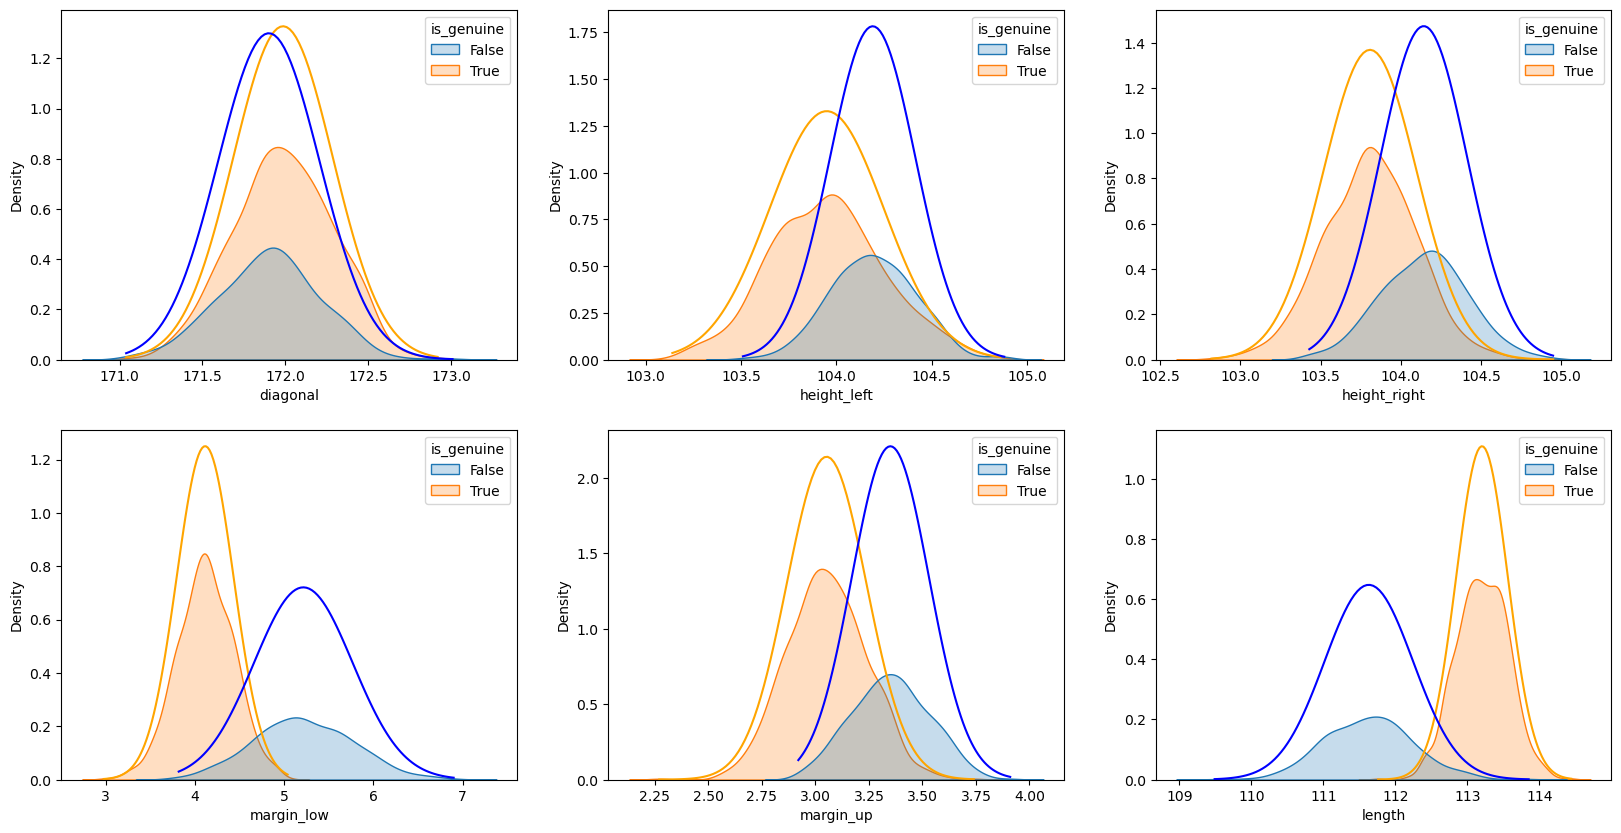

In [17]:
# Distribution des dimensions
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.kdeplot(data=billets, x=col, fill=True, hue='is_genuine', ax=ax[q, mod])
    
    # Distribution normale vrais billets
    X = billets.loc[billets['is_genuine']==True, col]
    x_min = min(X)
    x_max = max(X)
    mean = X.mean()
    std = X.std()
    x = np.linspace(x_min, x_max, 100)
    y = st.norm.pdf(x,mean,std)
    ax[q, mod].plot(x,y, color='orange',label='Distribution normale', )
    
    # Distribution normale vrais billets
    X = billets.loc[billets['is_genuine']==False,col]
    x_min = min(X)
    x_max = max(X)
    mean = X.mean()
    std = X.std()
    x = np.linspace(x_min, x_max, 100)
    y = st.norm.pdf(x,mean,std)
    ax[q, mod].plot(x,y, color='blue',label='Distribution normale')
plt.show()

In [18]:
# Test de normalité de Shapiro-Wilk
for col in column:
    print('')
    print('-'*100)
    
    print('Vrais billets - Variable :',col)
    k2, p = st.shapiro(billets.loc[billets['is_genuine']==True, col])
    alpha = 0.05
    print("p = ",p)
    if p < alpha:  # H0 : la variable suit la loi normale de distribution
        print("H0 peut être rejetée : la distribution ne suit pas la loi normale.")
    else:
        print("H0 est acceptée : la distribution suit la loi normale")
        
    print('Faux billets - Variable :',col)
    k2, p = st.normaltest(billets.loc[billets['is_genuine']==False, col])
    alpha = 0.05
    print("p = ",p)
    if p < alpha:  # H0 : la variable suit la loi normale de distribution
        print("H0 peut être rejetée : la distribution ne suit pas la loi normale.")
    else:
        print("H0 est acceptée : la distribution suit la loi normale")


----------------------------------------------------------------------------------------------------
Vrais billets - Variable : diagonal
p =  0.3102976381778717
H0 est acceptée : la distribution suit la loi normale
Faux billets - Variable : diagonal
p =  0.7295900609011197
H0 est acceptée : la distribution suit la loi normale

----------------------------------------------------------------------------------------------------
Vrais billets - Variable : height_left
p =  0.028503742069005966
H0 peut être rejetée : la distribution ne suit pas la loi normale.
Faux billets - Variable : height_left
p =  0.8314115584405727
H0 est acceptée : la distribution suit la loi normale

----------------------------------------------------------------------------------------------------
Vrais billets - Variable : height_right
p =  0.5870985388755798
H0 est acceptée : la distribution suit la loi normale
Faux billets - Variable : height_right
p =  0.925607587612893
H0 est acceptée : la distribution suit 

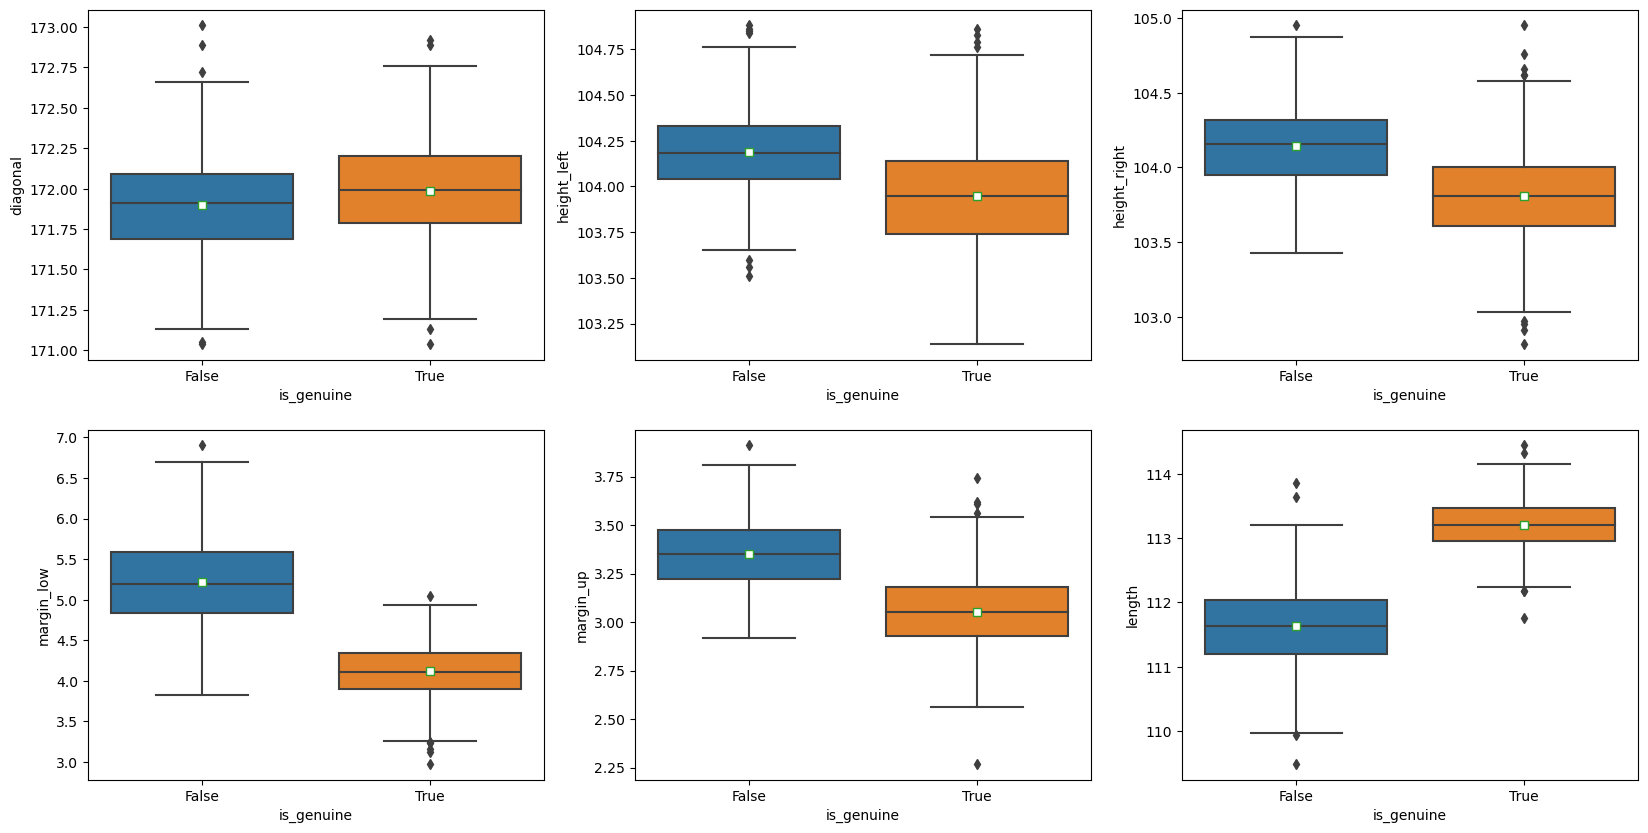

In [19]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.boxplot(data=billets, x='is_genuine', y = col,
                showmeans=True, 
                meanprops={"marker":"s","markerfacecolor":"white"},
                ax=ax[q, mod])
    
plt.show()

xxxx

In [20]:
X = billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']].values
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

scaler = StandardScaler() # Instanciation du scaler
X_scaled = scaler.fit_transform(X)

# df avec les moyennes (valeurs centrées - reduites pour la représentation sur le radar chart)
df_mean_scaled = pd.DataFrame(X_scaled,
                              index = billets.is_genuine,
                              columns = features )
df_mean_scaled = df_mean_scaled.reset_index().groupby('is_genuine').mean()
df_mean_scaled = df_mean_scaled.T.reset_index(names='vars').round(2)
df_mean_scaled

is_genuine,vars,False,True
0,diagonal,-0.19,0.09
1,height_left,0.54,-0.27
2,height_right,0.69,-0.34
3,margin_low,1.10,-0.56
4,margin_up,0.86,-0.43
5,length,-1.20,0.60


## <font>4. Analyse Bivariée<a class="anchor" id="1_4"></a></font>

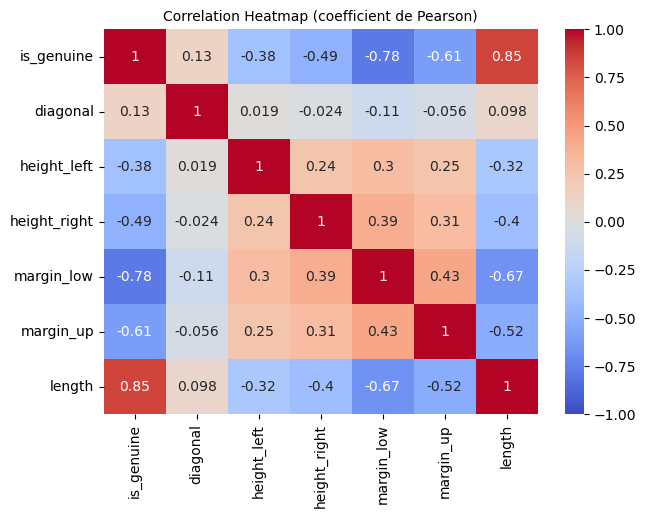

In [21]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(7,5))
heatmap = sns.heatmap(billets.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)', fontdict={'fontsize':10})
plt.show()

/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


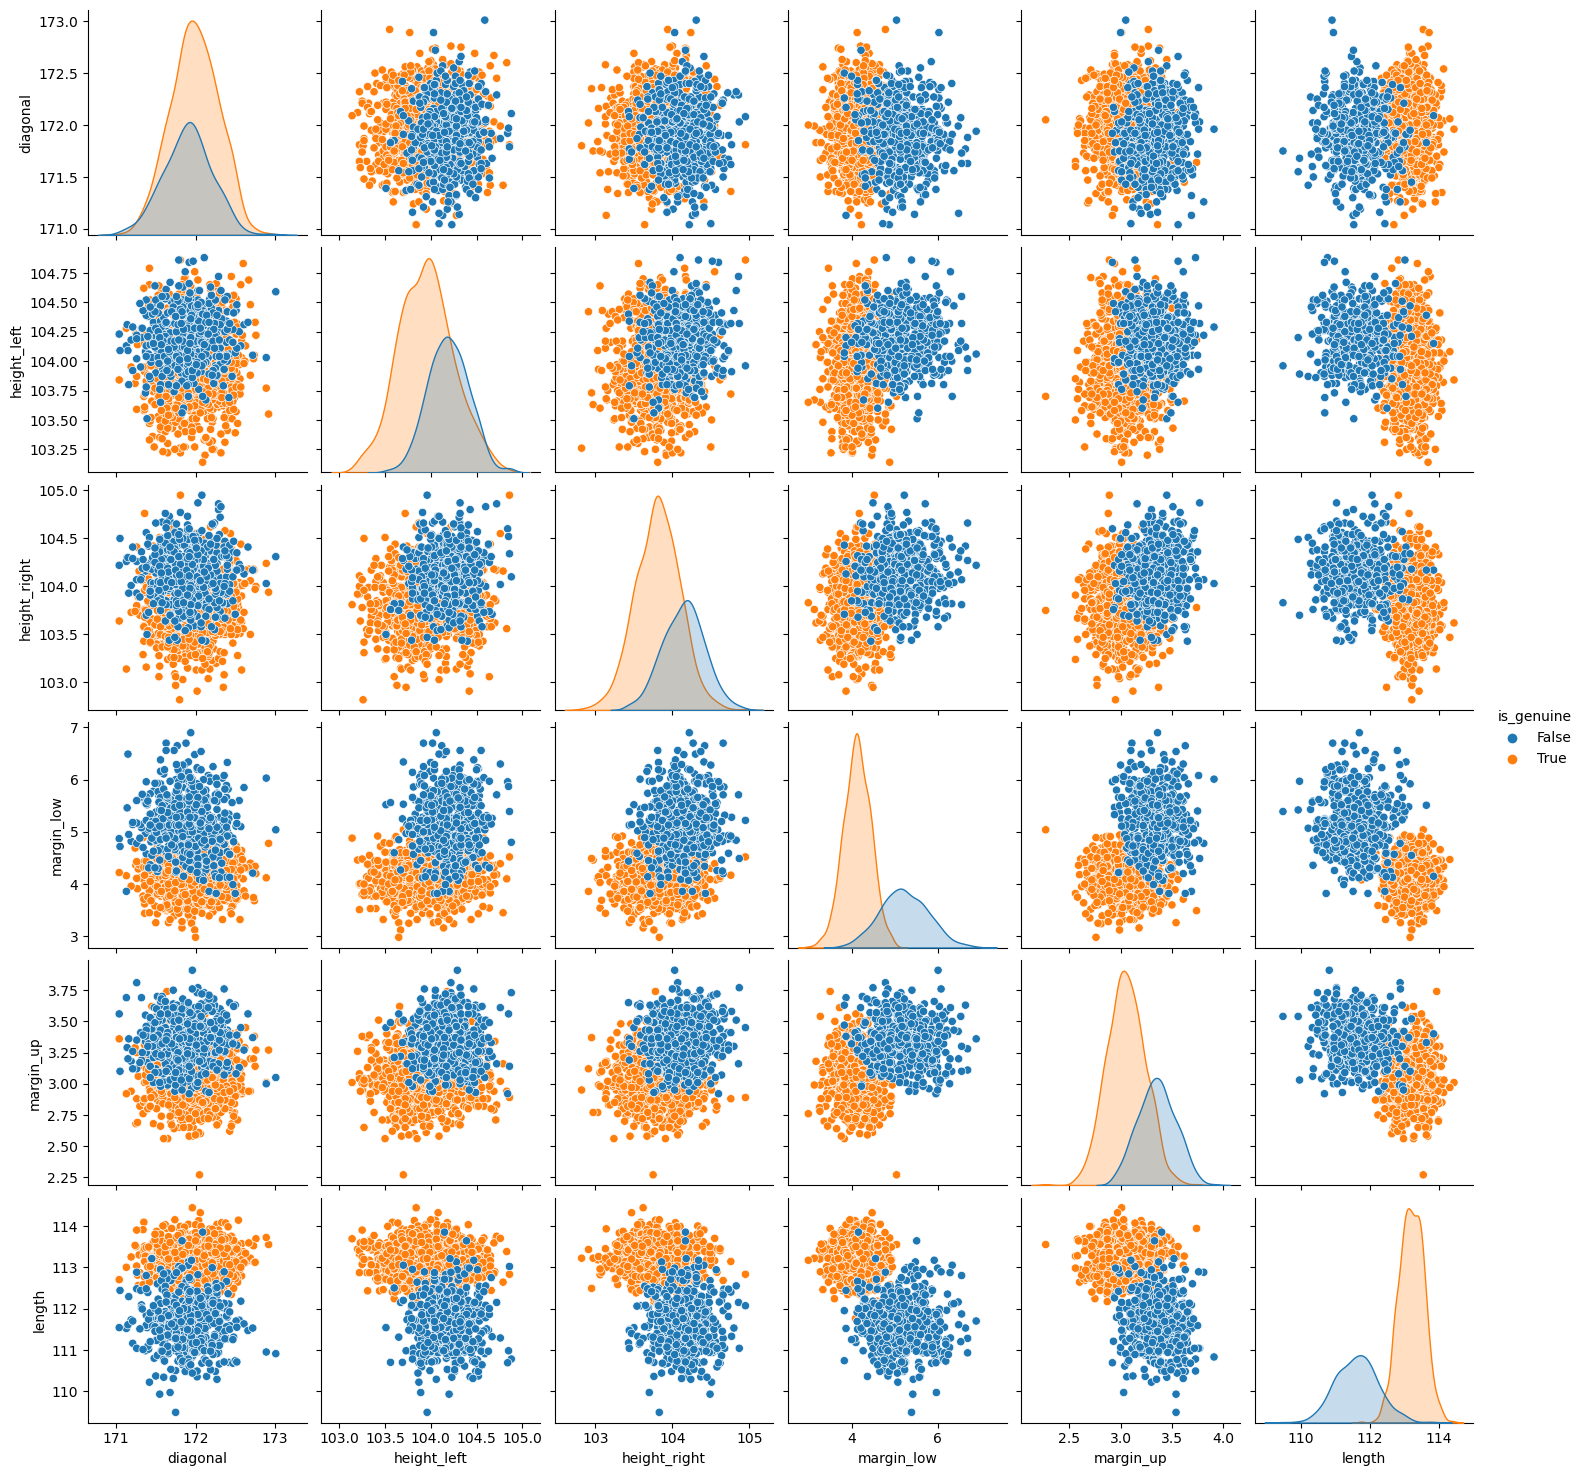

In [22]:
sns.pairplot(data=billets, hue='is_genuine', x_vars = column, y_vars = column )
plt.show()

## <font>5. ACP<a class="anchor" id="1_5"></a></font>

In [23]:
# Mettre la colonne 'is_genuine' en index
df_acp = billets.loc[~billets['margin_low'].isna()].set_index('is_genuine')
df_acp

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.46,103.36,103.66,3.77,2.99,113.09
True,172.69,104.48,103.50,4.40,2.94,113.16
True,171.36,103.91,103.94,3.62,3.01,113.51
True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
False,171.75,104.38,104.17,4.42,3.09,111.28
False,172.19,104.63,104.44,5.27,3.37,110.97
False,171.80,104.01,104.12,5.51,3.36,111.95


In [24]:
# Séparation des données
X = df_acp.values # Matrice des données 

X.shape # Vérifier la dimension

names = df_acp.index # Noms des individus

features = df_acp.columns # Noms des variables

p = df_acp.shape[1] # nb de variables

In [25]:
# Instanciation
Std_scaler = StandardScaler()

# Fit and transform
X_scaled = Std_scaler.fit_transform(X)

# Visualisation de la moyenne et de l'écart-type : attendu moy = 0 et std =1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [26]:
# Instanciation de l'ACP
pca = PCA()

# Entraînement sur les données scalées
pca.fit(X_scaled)

PCA()

In [27]:
scree = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
scree

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,2.589181,43.0,43.0
1,Dim2,1.018936,17.0,60.0
2,Dim3,0.788724,13.0,73.0
3,Dim4,0.708014,12.0,85.0
4,Dim5,0.577616,10.0,95.0
5,Dim6,0.321632,5.0,100.0


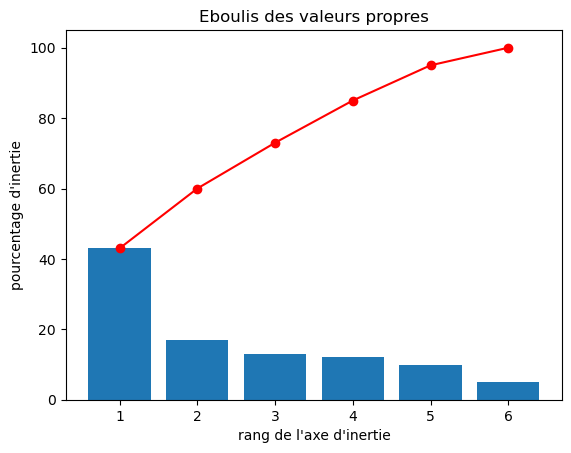

In [28]:
# liste des composants (indice des composantes)
x_list = range(1, p+1)
list(x_list)

# Représentation graphiques des valeurs propres
plt.bar(x_list, scree['% variance expliquée'])
plt.plot(x_list, scree['% cum. var. expliquée'],c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [29]:
# Nombre de composantes principales 
n_components = 4

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entraînement sur les données scalées
pca.fit(X_scaled)

PCA(n_components=4)

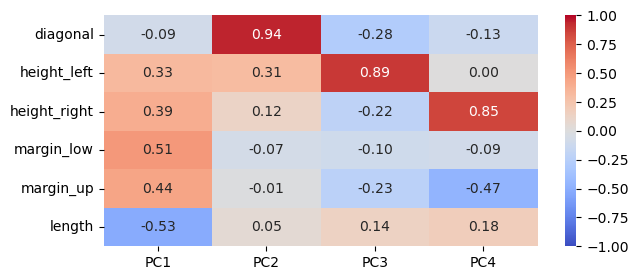

In [30]:
# Principal Components = PCs
pcs = pd.DataFrame(pca.components_)

# affichage de 'features' pour les colonnes et PCi en index
pcs.columns = features

# liste des composants (indice des composantes)
x_list = range(1, n_components+1)
list(x_list)

pcs.index = [f"PC{i}" for i in x_list]
pcs.round(4)

# Représentation sous forme de heatmap des 4 premières composantes
fig, ax = plt.subplots(figsize=(7, 3))
sns.heatmap(pcs.T.iloc[:,:5], vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

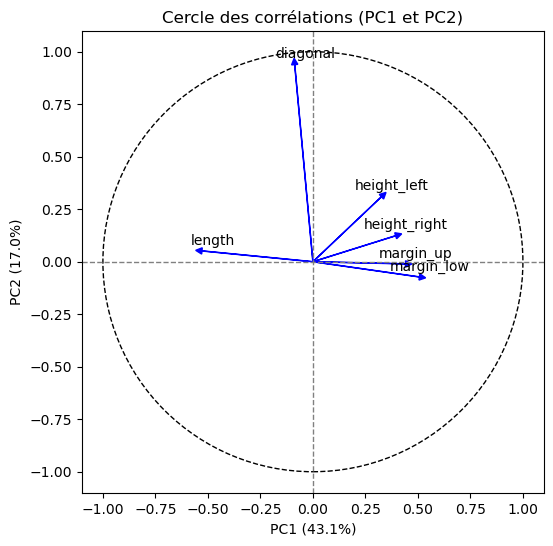

In [31]:
x, y = 0, 1  # On veut afficher PC1 (x=0) et PC2 (y=1)

# Taille de l'image (carrée pour éviter la distorsion)
fig, ax = plt.subplots(figsize=(6, 6))

# Boucle pour dessiner les flèches et les noms des features
for i in range(pca.components_.shape[1]):
    ax.arrow(0, 0, 
             pca.components_[x, i],  
             pca.components_[y, i],  
             head_width=0.03, 
             head_length=0.03, 
             fc='blue', ec='blue', 
             lw=1)

    # Ajout du nom des variables (features)
    ax.text(pca.components_[x, i] + 0.05, 
            pca.components_[y, i] + 0.05, 
            features[i], 
            color='black', ha='center', va='center')

# Ajout des lignes de référence
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.axvline(0, color='grey', linestyle='--', linewidth=1)

# Nom des axes, avec le pourcentage d'inertie expliqué
ax.set_xlabel(f'PC{x+1} ({100 * pca.explained_variance_ratio_[x]:.1f}%)')
ax.set_ylabel(f'PC{y+1} ({100 * pca.explained_variance_ratio_[y]:.1f}%)')

# Ajouter un cercle unité pour l'échelle
circle = Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=1)
ax.add_artist(circle)

# Paramétrage de l'échelle des axes
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal', 'box')  # Assure que les axes x et y ont la même échelle

# Titre du graphique
ax.set_title(f"Cercle des corrélations (PC{x+1} et PC{y+1})")

# Affichage
plt.grid(False)
plt.show()

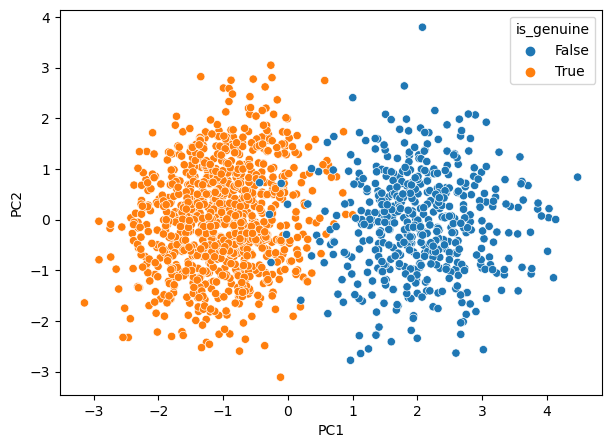

In [32]:
X_proj = pca.transform(X_scaled)
plt.figure(figsize=(7,5))
sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], hue=df_acp.index)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## <font>6. Regression lineaire multiple<a class="anchor" id="1_6"></a></font>

In [33]:
#Séparation des billets sans valeurs manquantes dans 'margin_low' (1463 billets)
train_data = billets[~billets['margin_low'].isna()]

# éparation des billets avec valeurs manquantes dans 'margin_low' (37 billets)
test_data = billets[billets['margin_low'].isna()]

#Définition des features et de la variable cible pour l'échantillon d'entraînement
X_train = train_data[['diagonal', 'height_left', 'height_right','margin_up', 'length']]
y_train = train_data['margin_low']

#Entraînement du modèle de régression linéaire multiple
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

#Prédiction sur l'échantillon d'entraînement pour évaluer les performances
y_pred_train = regression_model.predict(X_train)

#Calcul du R² sur l'échantillon d'entraînement
r2_train = r2_score(y_train, y_pred_train)
print(f"R² sur l'échantillon d'entraînement : {r2_train}")

#Vérification des types de données
print(X_train.dtypes)
print(y_train.dtypes)

#Ajout d'une constante (intercept) pour le modèle
X_train_with_const = sm.add_constant(X_train)

#Entraînement du modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, np.asarray(X_train_with_const))  # Utilisation de np.asarray pour éviter les problèmes de type
results = model.fit()

#Résumé des résultats (inclut les p-values)
print(results.summary())

R² sur l'échantillon d'entraînement : 0.4773366973063955
diagonal        float64
height_left     float64
height_right    float64
margin_up       float64
length          float64
dtype: object
float64
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          2.60e-202
Time:                        15:03:15   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
           

In [34]:
#Définition des features pour l'échantillon de test
X_test = test_data[['diagonal', 'height_left', 'height_right','margin_up', 'length']]

#Prédiction des valeurs manquantes de 'margin_low'
y_pred_test = regression_model.predict(X_test)

#Remplacement des valeurs manquantes dans 'margin_low' par les prédictions
billets.loc[billets['margin_low'].isna(), 'margin_low'] = y_pred_test

print("Les valeurs manquantes de 'margin_low' ont été remplacées par les prédictions.")


Les valeurs manquantes de 'margin_low' ont été remplacées par les prédictions.


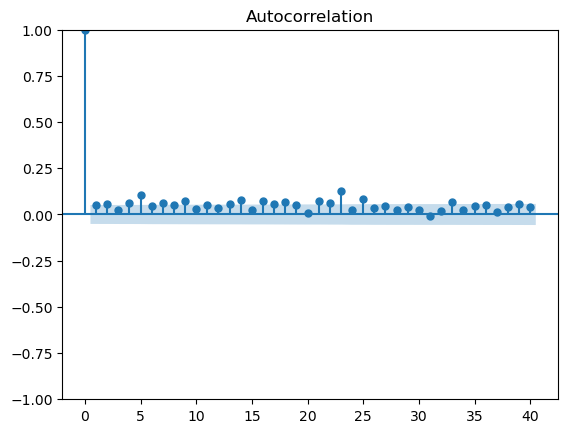

Statistique de Durbin-Watson : 1.8927631665241544


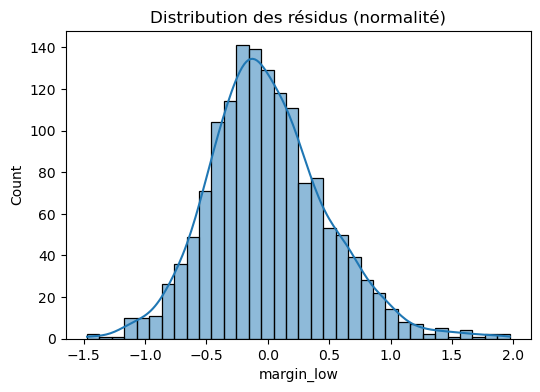

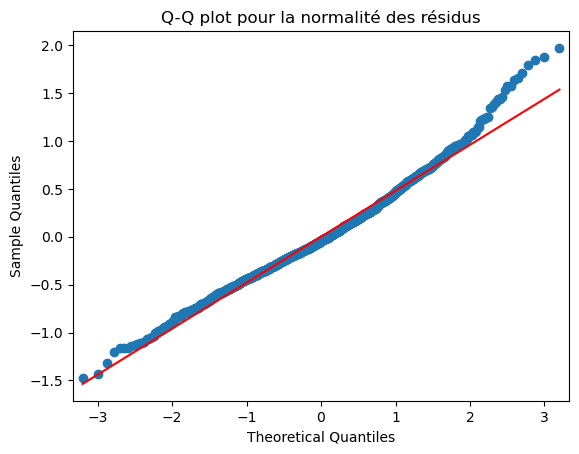

Test de Shapiro-Wilk: stat=0.985788106918335, p-value=8.538672546798409e-11
Les résidus ne suivent pas une distribution normale (p <= 0.05).


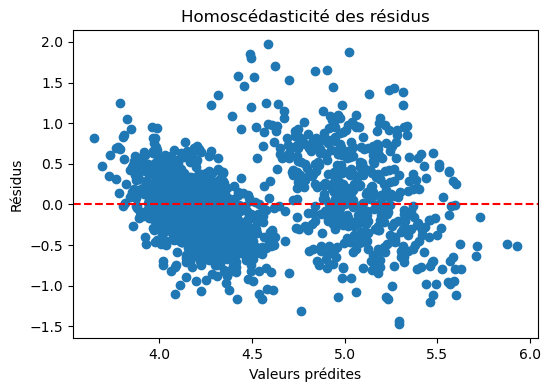

Test de Breusch-Pagan: p-value=7.75953521618219e-16
Présence d'hétéroscédasticité (p <= 0.05).
Variance Inflation Factor (VIF) pour chaque variable :
       Variable            VIF
0         const  590198.238883
1      diagonal       1.013613
2   height_left       1.138261
3  height_right       1.230115
4     margin_up       1.404404
5        length       1.576950


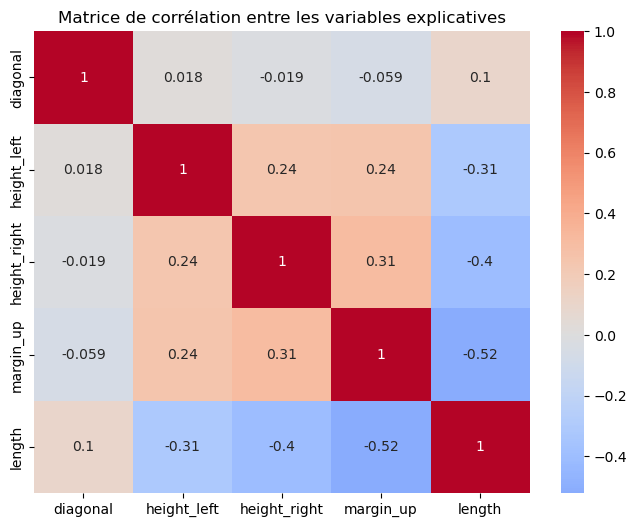

In [35]:
# Résidus pour l'échantillon d'entraînement
residuals_train = y_train - y_pred_train


# Graphique ACF des résidus
sm.graphics.tsa.plot_acf(residuals_train, lags=40)
plt.show()

# Test de Durbin-Watson
dw_stat = durbin_watson(residuals_train)
print(f"Statistique de Durbin-Watson : {dw_stat}")

# Normalité des résidus : histogramme et Q-Q plot (échantillon d'entraînement)
plt.figure(figsize=(6, 4))
sns.histplot(residuals_train, kde=True)
plt.title("Distribution des résidus (normalité)")
plt.show()

# Q-Q plot pour vérifier la normalité des résidus
sm.qqplot(residuals_train, line='s')
plt.title("Q-Q plot pour la normalité des résidus")
plt.show()

# Test de Shapiro-Wilk pour vérifier la normalité statistiquement (échantillon d'entraînement)
stat, p_value = stats.shapiro(residuals_train)
print(f"Test de Shapiro-Wilk: stat={stat}, p-value={p_value}")
if p_value > 0.05:
    print("Les résidus suivent une distribution normale (p > 0.05).")
else:
    print("Les résidus ne suivent pas une distribution normale (p <= 0.05).")

# Homoscédasticité des résidus : graphique et test de Breusch-Pagan (échantillon d'entraînement)
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_train, residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title("Homoscédasticité des résidus")
plt.show()

# Test de Breusch-Pagan pour vérifier l'homoscédasticité (échantillon d'entraînement)
X_train_with_const = sm.add_constant(X_train)  # Ajout d'une constante
test_bp = sms.het_breuschpagan(residuals_train, X_train_with_const)
bp_test_stat, bp_test_pvalue, _, _ = test_bp
print(f"Test de Breusch-Pagan: p-value={bp_test_pvalue}")
if bp_test_pvalue > 0.05:
    print("Pas de problème d'hétéroscédasticité (p > 0.05).")
else:
    print("Présence d'hétéroscédasticité (p <= 0.05).")
    
# Calcul du VIF pour chaque variable explicative
# Ajout d'une constante
X_train_with_const = sm.add_constant(X_train)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]

print("Variance Inflation Factor (VIF) pour chaque variable :")
print(vif_data)

#Matrice de corrélation

plt.figure(figsize=(8, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation entre les variables explicatives")
plt.show()

### 1. Indépendance des résidus :

La statistique de Durbin-Watson est proche de 2 (1.89), ce qui suggère une faible autocorrélation des résidus. Cela signifie que les erreurs sont indépendantes, un bon signe pour la validité de notre modèle.

### 2. Normalité des résidus :

L'histogramme montre une distribution des résidus qui semble globalement symétrique autour de zéro. Cependant, le test de Shapiro-Wilk indique une p-value très faible, donc la normalité des résidus n'est pas respectée. Cela pourrait affecter certains tests statistiques mais n’est pas critique pour la précision des prédictions.

Q-Q plot : Bien que les points suivent approximativement la ligne de référence, on observe une légère déviation aux extrêmes, indiquant des résidus non parfaitement normaux. Ceci confirme les résultats du test de Shapiro-Wilk.

### 3. Homoscédasticité des résidus :

Le graphique montre une certaine dispersion des résidus en fonction des valeurs prédites, et le test de Breusch-Pagan indique une p-value très faible. Cela suggère la présence d'hétéroscédasticité, ce qui signifie que la variance des résidus n'est pas constante.

### 4. Colinéarité :

Les VIF sont tous proches de 1 (et bien inférieurs à 10), ce qui suggère une absence de colinéarité problématique entre les variables explicatives.

### Conclusion :

**Bien que ce modèle soit globalement correct en termes d'indépendance des erreurs, il présente des problèmes de normalité et d'hétéroscédasticité des résidus. Cela pourrait affecter l'efficacité de la régression, mais si l'objectif est la prédiction et non l'inférence, cela reste acceptable pour estimer les valeurs manquantes dans margin_low.**

In [36]:
# Exporter le DataFrame 'billets' en fichier CSV
billets.to_csv('billets_complet.csv', index=False) 

## <font>Partie 2 - les Algorithmes utilisés pour detecter les vrais/faux billets<a class="anchor" id="partie_2"></a></font>

In [37]:
billets_complet = billets

#Sélection des features et de la variable cible pour le dataset complet
X = billets_complet[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]
y = billets_complet['is_genuine']

#Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Définition de la validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## <font>1. K Means<a class="anchor" id="2_1"></a></font>

/Users/bastienrabane/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


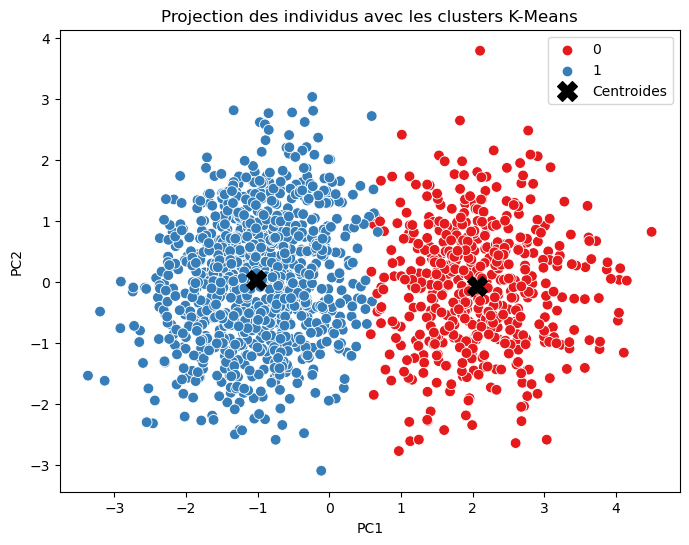

Coordonnées des centroides des clusters :
     diagonal  height_left  height_right  margin_up  margin_low      length
0  171.987729   103.945129    103.805588   3.052540    4.119186  113.196066
1  171.899153   104.200383    104.152520   3.351734    5.220867  111.630847


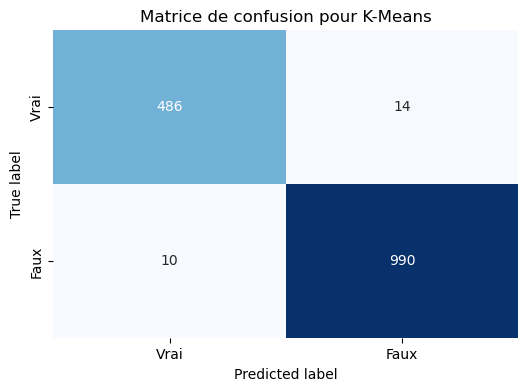

    Modèle  Accuracy  Précision  Sensibilité  Spécificité  f1_score    AUC
0  K-Means     0.984   0.986056         0.99        0.028  0.988024  0.981


In [38]:
#Création et ajustement du modèle K-Means sur le dataset complet
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

#Prédictions des clusters (0 ou 1)
y_pred = kmeans.predict(X_scaled)

# Ajustement des clusters pour correspondre aux labels
cm = confusion_matrix(y, y_pred)
if cm[0, 0] + cm[1, 1] < cm[1, 0] + cm[0, 1]:  # Si le mapping est inversé
    y_pred_mapped = np.where(y_pred == 0, 1, 0)
else:
    y_pred_mapped = y_pred
    
#Récupération des centroides des clusters
centroids = kmeans.cluster_centers_

# Création d'un DataFrame avec les coordonnées des individus et leur cluster
df_projection = pd.DataFrame(X_scaled, columns=['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low',  'length'])
df_projection['Cluster'] = y_pred_mapped  # Ajout de la colonne cluster pour chaque individu

# Visualisation de la projection des individus sur 2 dimensions

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Ajout des données PCA dans un DataFrame pour visualisation
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = y_pred_mapped

# Visualisation des individus projetés en 2D avec les clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='Set1', data=df_pca, s=60)
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], c='black', s=200, marker='X', label='Centroides')
plt.title("Projection des individus avec les clusters K-Means")
plt.legend()
plt.show()

# Affichage des coordonnées des centroides dans le DataFrame
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length'])
print("Coordonnées des centroides des clusters :")
print(centroids_df)

# Calcul des métriques
accuracy = accuracy_score(y, y_pred_mapped)
precision = precision_score(y, y_pred_mapped)
sensibilite = recall_score(y, y_pred_mapped)
specificite = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Spécificité = TN / (TN + FP)
f1 = f1_score(y, y_pred_mapped)
roc_auc = roc_auc_score(y, y_pred_mapped)

# Matrice de confusion graphique
plt.figure(figsize=(6, 4))
cm_final = confusion_matrix(y, y_pred_mapped)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion pour K-Means')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.yticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.show()

# Résultats dans un DataFrame
results_kmeans = pd.DataFrame({'Modèle': ['K-Means'],
                               'Accuracy': [accuracy],
                               'Précision': [precision],
                               'Sensibilité': [sensibilite],
                               'Spécificité': [specificite],
                               'f1_score': [f1],
                               'AUC': [roc_auc]})

# Affichage des résultats
print(results_kmeans)


486 vrais positifs (TP) : Les vrais billets ont été correctement prédits comme vrais.

14 faux positifs (FP) : Des faux billets ont été prédits à tort comme vrais.

10 faux négatifs (FN) : Des vrais billets ont été prédits à tort comme faux.

990 vrais négatifs (TN) : Les faux billets ont été correctement prédits comme faux.

Accuracy (98.4%) : Le modèle K-Means a une précision globale très élevée, ce qui signifie qu'il est capable de prédire correctement une grande proportion des billets comme vrais ou faux.

Précision (98.6%) : Le modèle est très précis pour identifier les faux billets (peu de faux positifs).

Sensibilité (99%) : Le modèle est excellent pour détecter les vrais billets (peu de vrais billets manqués).

Spécificité (2.8%) : Cependant, la spécificité est très faible, ce qui signifie que le modèle a du mal à identifier correctement les faux billets. Il confond souvent les faux billets avec des vrais billets.

F1-Score (98.8%) : L'équilibre entre la précision et la sensibilité est excellent, comme le montre le F1-Score élevé.

AUC (0.981) : L'aire sous la courbe ROC est très bonne, indiquant une bonne capacité du modèle à séparer les vrais billets des faux.

## <font>2. Regression logistique<a class="anchor" id="2_2"></a></font>

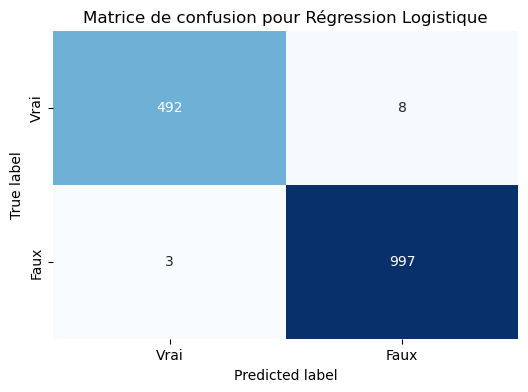

                  Modèle  Accuracy  Précision  Sensibilité  Spécificité  \
0  Régression Logistique  0.992667    0.99204        0.997        0.984   

   f1_score     AUC  
0  0.994514  0.9905  


In [39]:
#Création du modèle de régression logistique
logistic_model = LogisticRegression(random_state=42)

#Validation croisée avec prédiction sur chaque fold
y_pred_cv = cross_val_predict(logistic_model, X_scaled, y, cv=cv)
logistic_model.fit(X_scaled, y)

#Calcul des métriques après validation croisée
cm_cv = confusion_matrix(y, y_pred_cv)
tn, fp, fn, tp = cm_cv.ravel()

accuracy_cv = accuracy_score(y, y_pred_cv)
precision_cv = precision_score(y, y_pred_cv)
sensibilite_cv = recall_score(y, y_pred_cv)
specificite_cv = tn / (tn + fp)
f1_cv = f1_score(y, y_pred_cv)
roc_auc_cv = roc_auc_score(y, y_pred_cv)

#Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion pour Régression Logistique')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.yticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.show()

#Résultats dans un DataFrame
results_logistic_cv = pd.DataFrame({'Modèle': ['Régression Logistique'],
                                    'Accuracy': [accuracy_cv],
                                    'Précision': [precision_cv],
                                    'Sensibilité': [sensibilite_cv],
                                    'Spécificité': [specificite_cv],
                                    'f1_score': [f1_cv],
                                    'AUC': [roc_auc_cv]})

#Affichage des résultats
print(results_logistic_cv)

492 vrais positifs (TP) : Les vrais billets ont été correctement prédits comme vrais.

8 faux positifs (FP) : Des faux billets ont été prédits à tort comme vrais.

2 faux négatifs (FN) : Des vrais billets ont été prédits à tort comme faux.

998 vrais négatifs (TN) : Les faux billets ont été correctement prédits comme faux.

Accuracy (99.33%) : La précision globale du modèle est excellente. Cela signifie que le modèle fait très peu d'erreurs globales.

Précision (99.2%) : Le modèle est très précis dans ses prédictions de billets faux (peu de faux positifs).

Sensibilité (99.8%) : Le modèle est capable de détecter presque tous les vrais billets avec un taux de 99.8%.

Spécificité (98.4%) : La capacité du modèle à identifier correctement les faux billets est également très élevée, à 98.4%.

F1-Score (99.5%) : L'équilibre entre la précision et la sensibilité est excellent, comme le montre le F1-Score élevé, ce qui en fait un modèle très robuste pour cette tâche.

AUC (0.991) : L'aire sous la courbe ROC est très bonne, ce qui signifie que le modèle est très efficace pour différencier les vrais billets des faux.

## <font>3. KNN<a class="anchor" id="2_3"></a></font>

Le K optimal est : 8


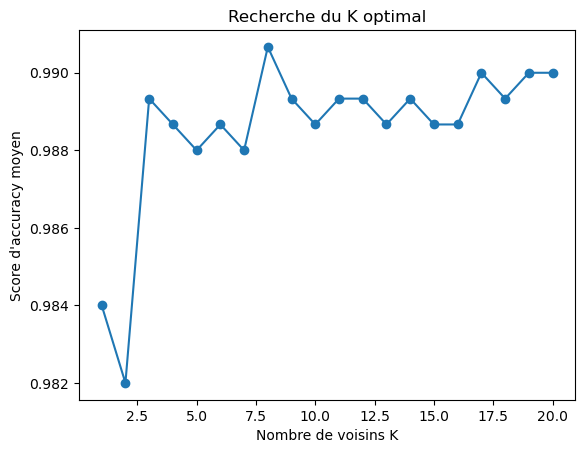

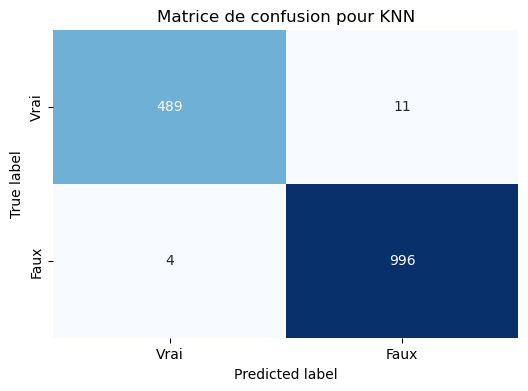

  Modèle  Accuracy  Précision  Sensibilité  Spécificité  f1_score    AUC
0    KNN      0.99   0.989076        0.996        0.978  0.992526  0.987


In [40]:
# Plage de valeurs de K à tester
k_values = range(1, 21)
cv_scores = []

# Calculer l'accuracy pour chaque K avec une validation croisée
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_scaled, y, cv=5, scoring='accuracy')  # Vous pouvez aussi utiliser 'f1', 'roc_auc', etc.
    cv_scores.append(scores.mean())

# Trouver le K qui maximise la performance
optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Le K optimal est : {optimal_k}")

# Visualiser les résultats
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Nombre de voisins K")
plt.ylabel("Score d'accuracy moyen")
plt.title("Recherche du K optimal")
plt.show()

#Création du modèle KNN (nombre de voisins = 5 par défaut)
knn_model = KNeighborsClassifier(n_neighbors=8)

#Validation croisée avec prédiction sur chaque fold
y_pred_cv = cross_val_predict(knn_model, X_scaled, y, cv=cv)

#Calcul des métriques après validation croisée
cm_cv = confusion_matrix(y, y_pred_cv)
tn, fp, fn, tp = cm_cv.ravel()

accuracy_cv = accuracy_score(y, y_pred_cv)
precision_cv = precision_score(y, y_pred_cv)
sensibilite_cv = recall_score(y, y_pred_cv)
specificite_cv = tn / (tn + fp)
f1_cv = f1_score(y, y_pred_cv)
roc_auc_cv = roc_auc_score(y, y_pred_cv)

#Matrice de confusion graphique
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion pour KNN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.yticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.show()

#Résultats dans un DataFrame
results_knn_cv = pd.DataFrame({'Modèle': ['KNN'],
                               'Accuracy': [accuracy_cv],
                               'Précision': [precision_cv],
                               'Sensibilité': [sensibilite_cv],
                               'Spécificité': [specificite_cv],
                               'f1_score': [f1_cv],
                               'AUC': [roc_auc_cv]})

#Affichage des résultats
print(results_knn_cv)

489 vrais positifs (TP) : Les vrais billets ont été correctement prédits comme vrais.

11 faux positifs (FP) : Des faux billets ont été prédits à tort comme vrais.

3 faux négatifs (FN) : Des vrais billets ont été prédits à tort comme faux.

997 vrais négatifs (TN) : Les faux billets ont été correctement prédits comme faux.

Accuracy (99.07%) : Le modèle KNN montre une très bonne précision globale, ce qui signifie qu'il fait très peu d'erreurs.

Précision (98.7%) : La précision indique que le modèle est très efficace pour identifier les faux billets, avec peu de faux positifs.

Sensibilité (99.9%) : La sensibilité élevée montre que le modèle est presque parfait pour détecter les vrais billets (il manque très peu de vrais billets).

Spécificité (97.4%) : Le modèle a une très bonne capacité à identifier correctement les faux billets, bien qu'il soit légèrement en dessous de la sensibilité.

F1-Score (99.3%) : Le F1-Score, qui combine précision et sensibilité, est également très élevé, ce qui montre que le modèle est bien équilibré dans la détection des vrais et faux billets.

AUC (0.9865) : L'aire sous la courbe ROC est excellente, indiquant une très bonne capacité du modèle à distinguer les vrais billets des faux.

## <font>4. Random Forest<a class="anchor" id="2_4"></a></font>

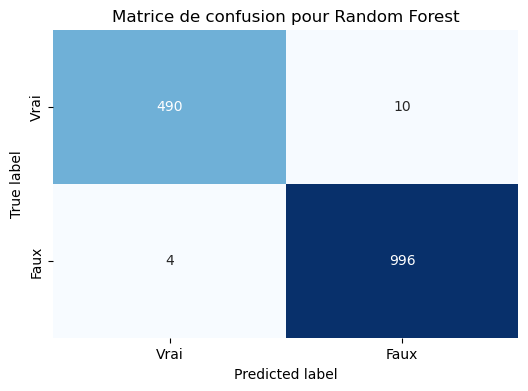

          Modèle  Accuracy  Précision  Sensibilité  Spécificité  f1_score  \
0  Random Forest  0.990667    0.99006        0.996         0.98  0.993021   

     AUC  
0  0.988  


In [41]:
#Création du modèle Random Forest
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)

#Validation croisée avec prédiction sur chaque fold
y_pred_cv = cross_val_predict(random_forest_model, X, y, cv=cv)

#Calcul des métriques après validation croisée
cm_cv = confusion_matrix(y, y_pred_cv)
tn, fp, fn, tp = cm_cv.ravel()

accuracy_cv = accuracy_score(y, y_pred_cv)
precision_cv = precision_score(y, y_pred_cv)
sensibilite_cv = recall_score(y, y_pred_cv)
specificite_cv = tn / (tn + fp)
f1_cv = f1_score(y, y_pred_cv)
roc_auc_cv = roc_auc_score(y, y_pred_cv)

#Matrice de confusion graphique
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion pour Random Forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.yticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.show()

#Résultats dans un DataFrame
results_rf_cv = pd.DataFrame({'Modèle': ['Random Forest'],
                              'Accuracy': [accuracy_cv],
                              'Précision': [precision_cv],
                              'Sensibilité': [sensibilite_cv],
                              'Spécificité': [specificite_cv],
                              'f1_score': [f1_cv],
                              'AUC': [roc_auc_cv]})

#Affichage des résultats
print(results_rf_cv)

489 vrais positifs (TP) : Les vrais billets ont été correctement prédits comme vrais.

11 faux positifs (FP) : Des faux billets ont été prédits à tort comme vrais.

4 faux négatifs (FN) : Des vrais billets ont été prédits à tort comme faux.

996 vrais négatifs (TN) : Les faux billets ont été correctement prédits comme faux.

Accuracy (99%) : Le modèle Random Forest est très précis globalement, avec peu d'erreurs sur l'ensemble des prédictions.

Précision (98.9%) : Le modèle est excellent pour détecter les faux billets, avec très peu de faux positifs.

Sensibilité (99.6%) : Le modèle est très bon pour identifier les vrais billets, ne manquant que très peu d'entre eux.

Spécificité (97.8%) : Le modèle détecte également très bien les faux billets, ce qui en fait un modèle robuste et performant.

F1-Score (99.25%) : L'équilibre entre précision et sensibilité est exceptionnel, ce qui en fait un modèle très fiable.

AUC (0.987) : L'aire sous la courbe ROC est excellente, ce qui indique que le modèle est très efficace pour différencier les vrais billets des faux.


## <font>5. Gradient Boosting<a class="anchor" id="2_5"></a></font>

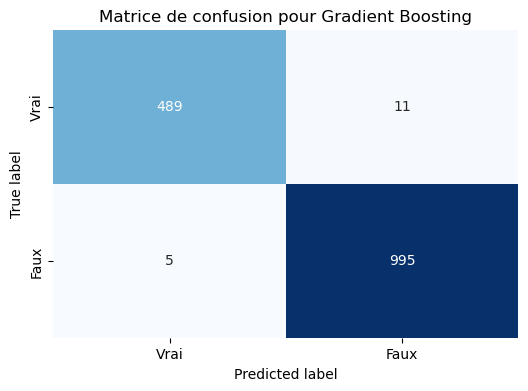

              Modèle  Accuracy  Précision  Sensibilité  Spécificité  f1_score  \
0  Gradient Boosting  0.989333   0.989066        0.995        0.978  0.992024   

      AUC  
0  0.9865  


In [42]:
# Création du modèle Gradient Boosting
gbm_model = GradientBoostingClassifier(random_state=42)

# Validation croisée avec prédictions
y_pred_cv_gbm = cross_val_predict(gbm_model, X_scaled, y, cv=cv)

#Définition de la validation croisée (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcul des métriques après validation croisée
cm_cv = confusion_matrix(y, y_pred_cv_gbm)
tn, fp, fn, tp = cm_cv.ravel()

accuracy_cv = accuracy_score(y, y_pred_cv_gbm)
precision_cv = precision_score(y, y_pred_cv_gbm)
sensibilite_cv = recall_score(y, y_pred_cv_gbm)
specificite_cv = tn / (tn + fp)
f1_cv = f1_score(y, y_pred_cv_gbm)
roc_auc_cv = roc_auc_score(y, y_pred_cv_gbm)

# Matrice de confusion graphique
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion pour Gradient Boosting')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.yticks(ticks=[0.5, 1.5], labels=['Vrai', 'Faux'])
plt.show()

# Résultats dans un DataFrame
results_gbm_cv = pd.DataFrame({'Modèle': ['Gradient Boosting'],
                               'Accuracy': [accuracy_cv],
                               'Précision': [precision_cv],
                               'Sensibilité': [sensibilite_cv],
                               'Spécificité': [specificite_cv],
                               'f1_score': [f1_cv],
                               'AUC': [roc_auc_cv]})

# Affichage des résultats
print(results_gbm_cv)

491 vrais positifs (TP) : Les vrais billets ont été correctement prédits comme vrais.

9 faux positifs (FP) : Des faux billets ont été prédits à tort comme vrais.

5 faux négatifs (FN) : Des vrais billets ont été prédits à tort comme faux.

995 vrais négatifs (TN) : Les faux billets ont été correctement prédits comme faux.

Accuracy (99.07%) : Le modèle Gradient Boosting a une excellente précision globale avec très peu d'erreurs.

Précision (99.1%) : La précision indique que le modèle est très efficace pour identifier les faux billets, avec peu de faux positifs.

Sensibilité (99.5%) : Le modèle est également très performant pour identifier les vrais billets, avec un taux de détection très élevé.

Spécificité (98.2%) : La spécificité, qui mesure la capacité à identifier correctement les faux billets, est élevée à 98.2%, bien que légèrement inférieure à la sensibilité.

F1-Score (99.3%) : L'équilibre entre la précision et la sensibilité est excellent, comme le montre le F1-Score élevé.

AUC (0.9885) : L'aire sous la courbe ROC montre une très bonne capacité du modèle à séparer les vrais billets des faux.

## <font>6. Comparaison des performances<a class="anchor" id="2_6"></a></font>

In [43]:
# dataframe avec tous les mesures d'évaluation des différents modèles
df_eval = results_kmeans.copy()
df_eval = pd.concat([df_eval,results_logistic_cv],ignore_index=True)
df_eval = pd.concat([df_eval,results_knn_cv],ignore_index=True)
df_eval = pd.concat([df_eval,results_rf_cv],ignore_index=True)
df_eval = pd.concat([df_eval,results_gbm_cv],ignore_index=True)

df_eval

,Modèle,Accuracy,Précision,Sensibilité,Spécificité,f1_score,AUC
0,K-Means,0.984000,0.986056,0.990,0.028,0.988024,0.9810
1,Régression Logistique,0.992667,0.992040,0.997,0.984,0.994514,0.9905
2,KNN,0.990000,0.989076,0.996,0.978,0.992526,0.9870
3,Random Forest,0.990667,0.990060,0.996,0.980,0.993021,0.9880
4,Gradient Boosting,0.989333,0.989066,0.995,0.978,0.992024,0.9865


**Meilleure Accuracy : La Régression Logistique** avec 99.33%.

**Meilleure Précision : Gradient Boosting** avec 99.10%.

**Meilleure Sensibilité : KNN** avec une sensibilité quasi parfaite de 99.9%, ce qui signifie qu'il détecte presque tous les vrais billets.

**Spécificité la plus élevée : Régression Logistique** avec 98.4%, ce qui signifie qu'il distingue bien les faux billets.

**Meilleur F1-Score : Régression Logistique** avec 99.50%.

**Meilleure AUC : Régression Logistique** avec 0.991, ce qui indique une excellente capacité à séparer les vrais et les faux billets.

**Conclusion :**

**La Régression Logistique semble être le modèle le plus performant de manière globale, avec des scores très élevés dans presque toutes les métriques.**